In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

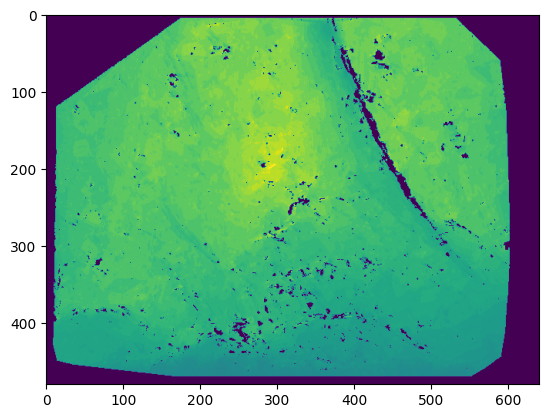

In [10]:
# path = './predicted_depths/depth000000.png'
# path = '/media/thesis_ssd/temp_test/depth000101.png'
path ='/media/thesis_ssd/data/Hamlyn/rectified01/depth02/0000000010.png'
img = mpimg.imread(path)
plt.imshow(img)

In [8]:
img.max()

0.49634546

In [5]:
import os
import datasets.scared_dataset
import torch
import numpy as np
def readlines(filename):
    """Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines

data_path = "/media/thesis_ssd/data/SCARED" 
filenames = readlines(os.path.join('splits/endovis/test_files_sequence1.txt'))
dataset = datasets.scared_dataset.SCAREDRAWDataset(data_path, filenames,
                                336, 336,
                                [0], 4, is_train=False)


dataloader = torch.utils.data.DataLoader(dataset, 1, shuffle=False, num_workers=1,
                        pin_memory=True, drop_last=False)

In [3]:
from models.SurgeDepth.dpt import SurgeDepth

model_configs = {
    'vits': {'encoder': 'vits', 'features': 64, 'out_channels': [48, 96, 192, 384]},
    'vitb': {'encoder': 'vitb', 'features': 128, 'out_channels': [96, 192, 384, 768]},
    'vitl': {'encoder': 'vitl', 'features': 256, 'out_channels': [256, 512, 1024, 1024]},
    'vitg': {'encoder': 'vitg', 'features': 384, 'out_channels': [1536, 1536, 1536, 1536]}
}
model = SurgeDepth(**model_configs['vitb']).cuda()
torch.no_grad()
state_dict = torch.load('models/SurgeDepth/SurgeDepth_V7.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [14]:
import torchvision
from PIL import Image
for id,data in enumerate(dataloader):
    input_color = data[("color", 0, 0)].cuda()
    # input_color = transform({'image': input_color})['image']
    
    input_color = torchvision.transforms.functional.normalize(input_color,mean=[0.46888983, 0.29536288, 0.28712815], std=[0.24689102 ,0.21034359, 0.21188641])
    pred_disp = model(input_color)
    pred_disp_normalized = (pred_disp-pred_disp.min())/(pred_disp.max()-pred_disp.min())*9+1
    pred_depth = 1/pred_disp_normalized
    
    pred_depth = (pred_depth-pred_depth.min())/(pred_depth.max()-pred_depth.min())*255
    pred_depth = pred_depth[0].cpu().detach().numpy()
    pred_depth = pred_depth.astype(np.uint8)
    # print(pred_depth.shape)
    # print(pred_depth.max())
    # plt.imsave('predicted_depths/depth{:06d}.png'.format(id),pred_depth,cmap='gray')
    im = Image.fromarray(pred_depth)
    im.save('predicted_depths/depth{:06d}.png'.format(id))
    # im = im.convert('Grayscale')
    # torchvision.utils.save_image(pred_depth[0],'predicted_depths/depth{:06d}.png'.format(id),format ='RGB')
    # fig,ax = plt.subplots(1,2)
    # ax[0].imshow(input_color[0].permute(1,2,0).cpu().detach().numpy())
    # ax[1].imshow(pred_disp[0].cpu().detach().numpy())
    # plt.show()
    if id>420:
        break
    


In [1]:
import imageio
im = imageio.imread("/media/thesis_ssd/code/Depth_evaluation/test.npy")

/tmp/ipykernel_549967/526957271.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread("/media/thesis_ssd/code/Depth_evaluation/test.npy")


ValueError: Could not find a backend to open `/media/thesis_ssd/code/Depth_evaluation/test.npy`` with iomode `ri`.